This notebook has stupid dataset and stupid training. It only has illustrative purpose.

With **nnj** library, Laplace Approximation scales **linearly** (with approx backprop). Here we show it with:
- 21M parameters U-Net
- 512x512 images input

In [1]:
import torch
import nnj
import matplotlib.pyplot as plt

/zhome/01/c/173531/miniconda3/envs/gauss/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

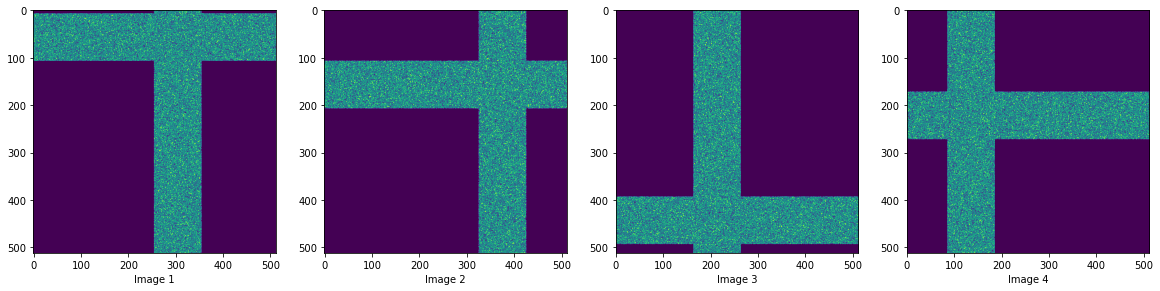

In [2]:
# Create a very stupid high resolution dataset
batch_size = 4
x = torch.zeros(batch_size, 1, 512, 512)
idx = torch.randint(512 - 100, (batch_size, 2))
for b in range(batch_size):
    x[b, :, idx[b, 0] : idx[b, 0] + 100, :] = torch.rand(1, 1, 100, 512)
    x[b, :, :, idx[b, 1] : idx[b, 1] + 100] = torch.rand(1, 1, 512, 100)
# Visualize it
f, axarr = plt.subplots(1, batch_size, figsize=(20, 5))
for b, ax in enumerate(axarr.flat):
    ax.imshow(x[b, 0].numpy())
    ax.set_xlabel(f"Image {b+1}")
plt.show()

### Model

In [3]:
UNet = nnj.Sequential(
    nnj.Conv2d(1, 64, 3, stride=1, padding=1),
    nnj.Tanh(),
    nnj.Conv2d(64, 64, 3, stride=1, padding=1),
    nnj.Tanh(),
    nnj.SkipConnection(
        nnj.MaxPool2d(2),
        nnj.Conv2d(64, 128, 3, stride=1, padding=1),
        nnj.Tanh(),
        nnj.Conv2d(128, 128, 3, stride=1, padding=1),
        nnj.Tanh(),
        nnj.SkipConnection(
            nnj.MaxPool2d(2),
            nnj.Conv2d(128, 256, 3, stride=1, padding=1),
            nnj.Tanh(),
            nnj.Conv2d(256, 256, 3, stride=1, padding=1),
            nnj.Tanh(),
            nnj.SkipConnection(
                nnj.MaxPool2d(2),
                nnj.Conv2d(256, 512, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Conv2d(512, 512, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.SkipConnection(
                    nnj.MaxPool2d(2),
                    nnj.Conv2d(512, 1024, 3, stride=1, padding=1),
                    nnj.Tanh(),
                    nnj.Conv2d(1024, 512, 3, stride=1, padding=1),
                    nnj.Tanh(),
                    nnj.Upsample(scale_factor=2),
                ),
                nnj.Conv2d(1024, 512, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Conv2d(512, 256, 3, stride=1, padding=1),
                nnj.Tanh(),
                nnj.Upsample(scale_factor=2),
            ),
            nnj.Conv2d(512, 256, 3, stride=1, padding=1),
            nnj.Tanh(),
            nnj.Conv2d(256, 128, 3, stride=1, padding=1),
            nnj.Tanh(),
            nnj.Upsample(scale_factor=2),
        ),
        nnj.Conv2d(256, 128, 3, stride=1, padding=1),
        nnj.Tanh(),
        nnj.Conv2d(128, 64, 3, stride=1, padding=1),
        nnj.Tanh(),
        nnj.Upsample(scale_factor=2),
    ),
    nnj.Conv2d(128, 64, 3, stride=1, padding=1),
    nnj.Tanh(),
    nnj.Conv2d(64, 64, 3, stride=1, padding=1),
    nnj.Tanh(),
    nnj.Conv2d(64, 1, 1, stride=1, padding=0),
)
print(f"This network has {UNet._n_params} parameters")

This network has 21976513 parameters


In [4]:
# Some extremely stupid training
for step in range(1):
    # forward pass
    with torch.no_grad():
        val = UNet(x)
    # made-up no-sense target label
    target = (x > 0).float()
    # gradient of the l2 loss
    residual = target - val
    # backpropagation
    gradient = UNet.vjp(x, val, residual.reshape(batch_size, -1), wrt="weight").sum(dim=0)
    # gradient step
    UNet.set_weight(UNet.get_weight() + gradient)

### Laplace Approximation

Distribution on the weights

In [5]:
# mode is MAP parameter
parameter_mean = UNet.get_weight()

# LA says that precision is GGN plus prior precision
# compute GGN
parameter_precision = UNet.jTmjp(x, None, None, wrt="weight", from_diag=True, to_diag=True, diag_backprop=True)
# sum over batch size
parameter_precision = parameter_precision.sum(dim=0)
# add prior precision
parameter_precision += torch.ones(UNet._n_params)

# covariance is inverse of precision
parameter_covariance = 1.0 / parameter_precision
# standard deviation is square root of covariance
parameter_std = parameter_covariance**0.5

Distribution on the predictions

In [6]:
vals = []
for sample in range(15):
    # samples are given by std * eps for eps sampled from N(0,1)
    parameter_sampled = parameter_std * torch.randn(UNet._n_params)
    # set the sampled parameter to the model
    UNet.set_weight(parameter_sampled)
    # do one forward pass for each model
    with torch.no_grad():
        val = UNet(x)
    vals.append(val)
vals = torch.stack(vals, dim=0)

# Compute empirical mean and standard deviation of the predictions
val_mean = torch.mean(vals, dim=0)
val_std = torch.std(vals, dim=0)

### Plot stuff

Plot distribution on the weights

In [7]:
# plt.plot(parameter_mean.numpy())
# plt.plot(parameter_std.numpy())

Plot distribution on the predictions (for all images in the batch)

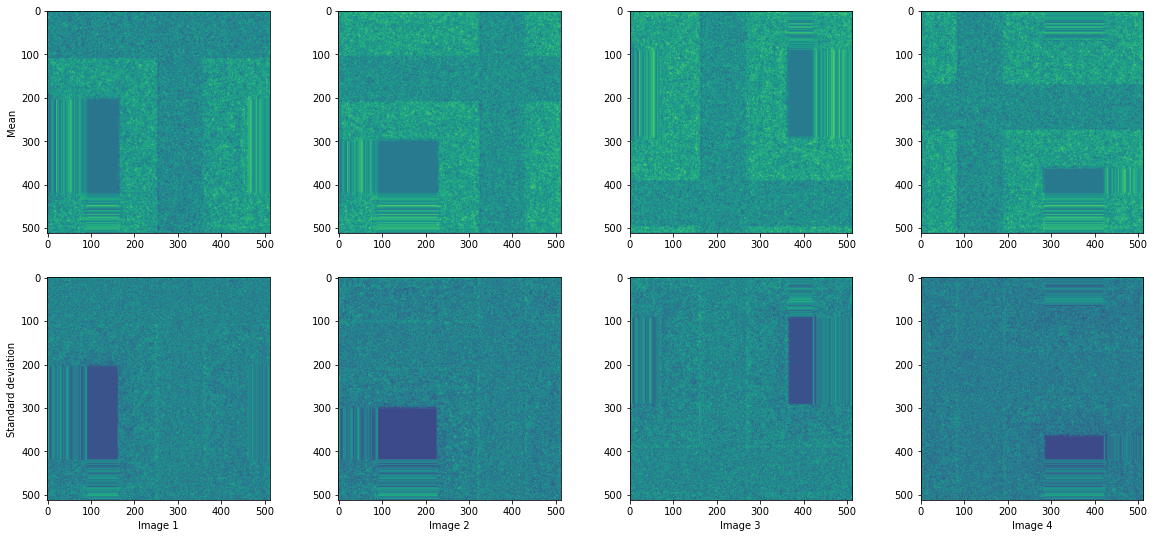

In [8]:
f, axarr = plt.subplots(2, 4, figsize=(20, 9))
for b in range(batch_size):
    axarr[0, b].imshow(val_mean[b, 0].numpy())
    # axarr[0,b].axis('off')
    axarr[1, b].imshow(val_std[b, 0].numpy())
    axarr[1, b].set_xlabel(f"Image {b+1}")
axarr[0, 0].set_ylabel("Mean")
axarr[1, 0].set_ylabel("Standard deviation")
plt.show()